In [15]:
import pandas as pd
import seaborn as sns
import sklearn
from tensorflow import keras

In [16]:
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Input, Dropout, BatchNormalization

In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler

In [9]:
from tensorflow.keras.models import load_model, Model

In [10]:
from tensorflow.keras import regularizers

In [11]:
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [12]:
# from numpy.random import seed
# from tensorflow import random

In [13]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

(Class below comes from: https://stackoverflow.com/questions/67271590/issue-with-custom-metric-auc-callback-for-keras)

In [14]:
# Custom skelearn-based AUROC calculation class for use with the FULL validation 
#   set (not just mini-batches) at the end of each training epoch

class ROAUCMetrics(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.valid_x = val_data[0]
        self.valid_y = val_data[1]

    def on_train_begin(self, logs={}):
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.valid_x)
        val_auc = roc_auc_score(self.valid_y, pred,  average='micro')
        print('\nval-roc-auc: %s' % (str(round(val_auc,4))),end=100*' '+'\n\n')
        self.val_aucs.append(val_auc)
        return

# 1) Import the training data

In [14]:
X_train = np.load('data2/X_baby_train.dat')
y_train = np.load('data2/y_baby_train.dat')

X_val = np.load('data2/X_baby_val.dat')
y_val = np.load('data2/y_baby_val.dat')

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(985, 224, 273, 1)
(985, 4)
(247, 224, 273, 1)
(247, 4)


In [16]:
# Need these to be float32 format for custom loss function to work

y_train = y_train.astype(float)
y_val = y_val.astype(float) 

# 6) Let's Try a Pre-trained Model (VGG16) on just the last target (diagnosis = 'Pleural Effusion')

In [ ]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

In [27]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [28]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [29]:
keras.backend.clear_session()

dropout = 0.25

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu')(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [31]:
initial_learning_rate = 0.0002828
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [32]:
model.optimizer.get_config()['learning_rate']

0.0002828

In [33]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_6.{epoch:02d}-{val_loss:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0002828
4/4 [==============================] - 421s 112s/step - loss: 0.7633 - val_loss: 0.6366

val-roc-auc: 0.5731                                                                                                    

Epoch 2/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 419s 113s/step - loss: 0.6906 - val_loss: 0.6246

val-roc-auc: 0.6099                                                                                                    

Epoch 3/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 412s 104s/step - loss: 0.6507 - val_loss: 0.6138

val-roc-auc: 0.6664                                                                                                    

Epoch 4/100
Learning Rate: 0.00028279999969527125
4/4 [==============================] - 365s 89s/step - loss: 0.6076 - val_loss: 0.5896

val-roc-auc: 0.6795                                                                            

In [ ]:
# Best model is from epoch 15: models_baby/model_6.15-0.51.hdf5

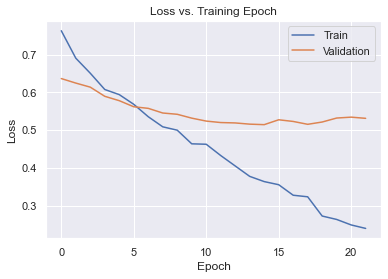

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [35]:
y_pred = model.predict(X_val)

In [36]:
# Initial LR=0.0002828, batch_size=256
roc_auc_score(y_val[:,target], y_pred)

0.7516795311606632

In [777]:
# Initial LR=0.00005, batch_size=32
roc_auc_score(y_val[:,target], y_pred)

0.7441395082904516

In [767]:
# Initial LR=0.0001, batch_size=32
roc_auc_score(y_val[:,target], y_pred)

0.7536449399656946

# 7) Let's Try a Pre-trained Model (VGG16) on just the first target (diagnosis = 'Atelectasis')

In [165]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [166]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [167]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [168]:
keras.backend.clear_session()

dropout = 0.25

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu')(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [169]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [170]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [171]:
model.optimizer.get_config()['learning_rate']

0.0005

In [172]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_7.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 400s 106s/step - loss: 0.8760 - val_loss: 0.6432

val-roc-auc: 0.5601                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 400s 106s/step - loss: 0.7028 - val_loss: 0.6157

val-roc-auc: 0.5741                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 400s 101s/step - loss: 0.6660 - val_loss: 0.6101

val-roc-auc: 0.5933                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 408s 104s/step - loss: 0.6541 - val_loss: 0.6228

val-roc-auc: 0.599                                                                                  

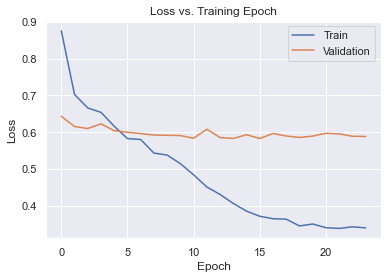

In [173]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [174]:
y_pred = model.predict(X_val)

In [175]:
# batch_size=256, initial_lr=0.0005

roc_auc_score(y_val[:,target], y_pred)

0.6467350885021567

# 8) Now (VGG16) w/ trainable layer_5 (just first target, 'Atelectasis') and drop Dense layers

In [176]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [177]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [178]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [179]:
keras.backend.clear_session()

# dropout = 0.25

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [180]:
out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
# x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
# x = Dense(units=64, activation='relu')(x)
# x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [181]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 28673     
Total params: 14,743,391
Trainable params: 7,108,127
Non-trainable params: 7,635,264
_________________________________________________________________


In [182]:
initial_learning_rate = 0.0005
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [183]:
model.optimizer.get_config()['learning_rate']

0.0005

In [184]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.005)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_8.{epoch:02d}-{auc:.2f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0005
4/4 [==============================] - 413s 110s/step - loss: 1.0106 - val_loss: 0.6603

val-roc-auc: 0.5391                                                                                                    

Epoch 2/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 412s 110s/step - loss: 0.6368 - val_loss: 0.6469

val-roc-auc: 0.5959                                                                                                    

Epoch 3/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 417s 106s/step - loss: 0.6339 - val_loss: 0.6287

val-roc-auc: 0.6203                                                                                                    

Epoch 4/100
Learning Rate: 0.0005000000237487257
4/4 [==============================] - 415s 105s/step - loss: 0.6207 - val_loss: 0.6188

val-roc-auc: 0.6252                                                                                 

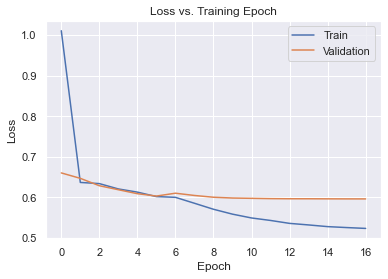

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [186]:
y_pred = model.predict(X_val)

In [187]:
# batch_size=256, initial_lr=0.0005

roc_auc_score(y_val[:,target], y_pred)

0.6430908820467053

In [189]:
y_pred_train = model.predict(X_train)

In [190]:
roc_auc_score(y_train[:,target], y_pred_train)

0.6691842900302114

# 9) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (first target, 'Atelectasis')

In [250]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [251]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [252]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [253]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [254]:
dropout = 0.3
l1_reg = 0.000001
l2_reg = 0.00001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [255]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [256]:
initial_learning_rate = 0.0001
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [257]:
model.optimizer.get_config()['learning_rate']

0.0001

In [258]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_9.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0001
4/4 [==============================] - 424s 112s/step - loss: 0.6832 - val_loss: 0.6500

val-roc-auc: 0.5557                                                                                                    

Epoch 2/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 452s 121s/step - loss: 0.6473 - val_loss: 0.6435

val-roc-auc: 0.575                                                                                                    

Epoch 3/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 390s 95s/step - loss: 0.6367 - val_loss: 0.6376

val-roc-auc: 0.5971                                                                                                    

Epoch 4/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 405s 115s/step - loss: 0.6022 - val_loss: 0.6289

val-roc-auc: 0.6151                                                                                   

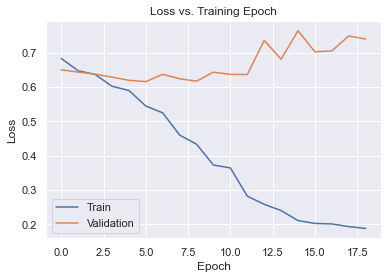

In [259]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [260]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

2022-01-19 22:15:58.608285: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_101 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_101 is not found


2022-01-19 22:15:58.608380: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_101 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_101 is not found


	 [[{{node PyFunc}}]]


In [261]:
target

0

In [262]:
# Dropout=0.3, L1=0.000001, L2=0.00001

print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

Validation AUC: 0.6603
Training AUC: 0.8216


In [230]:
# Dropout = 0.3, No regularization

print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

Validation AUC: 0.6621
Training AUC: 0.7776


# 9b) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (first target, 'Atelectasis')

In [263]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [264]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [265]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [266]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [267]:
dropout = 0.4
l1_reg = 0.000001
l2_reg = 0.00001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [268]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [269]:
initial_learning_rate = 0.0001
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [270]:
model.optimizer.get_config()['learning_rate']

0.0001

In [271]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_9.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.0001
4/4 [==============================] - 433s 114s/step - loss: 0.7063 - val_loss: 0.6602

val-roc-auc: 0.5689                                                                                                    

Epoch 2/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 421s 111s/step - loss: 0.6583 - val_loss: 0.6487

val-roc-auc: 0.5776                                                                                                    

Epoch 3/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 441s 113s/step - loss: 0.6457 - val_loss: 0.6443

val-roc-auc: 0.5874                                                                                                    

Epoch 4/100
Learning Rate: 9.999999747378752e-05
4/4 [==============================] - 441s 112s/step - loss: 0.6170 - val_loss: 0.6309

val-roc-auc: 0.604                                                                                  

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [ ]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [ ]:
target

In [ ]:
# dropout = 0.4
# l1_reg = 0.000001
# l2_reg = 0.00001

print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

# 9c) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (first target, 'Atelectasis')

In [294]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

In [295]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [296]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [297]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if 'block5_' not in layer.name:
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [298]:
dropout = 0.3
l1_reg = 0.00001
l2_reg = 0.0001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, 
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64,
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [299]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [300]:
initial_learning_rate = 0.00025
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [301]:
model.optimizer.get_config()['learning_rate']

0.00025

In [302]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_9.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.00025
4/4 [==============================] - 326s 87s/step - loss: 1.0344 - val_loss: 0.9336

val-roc-auc: 0.5132                                                                                                    

Epoch 2/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 311s 84s/step - loss: 0.9301 - val_loss: 0.9044

val-roc-auc: 0.5316                                                                                                    

Epoch 3/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 318s 79s/step - loss: 0.9053 - val_loss: 0.8801

val-roc-auc: 0.5801                                                                                                    

Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 359s 95s/step - loss: 0.8789 - val_loss: 0.8562

val-roc-auc: 0.5959                                                                                    

2022-01-20 04:17:24.965506: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_107 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_107 is not found


2022-01-20 04:17:24.965593: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_107 is not found
Traceback (most recent call last):

  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_107 is not found


	 [[{{node PyFunc}}]]
2022-01-20 04:17:25.095634: W tensorflow/core/framework/op_kernel.cc:

Epoch 26/100
Learning Rate: 3.900000137946336e-06
4/4 [==============================] - 423s 113s/step - loss: 0.6665 - val_loss: 0.7242

val-roc-auc: 0.6771                                                                                                    

Epoch 27/100
Learning Rate: 3.900000137946336e-06
4/4 [==============================] - 417s 106s/step - loss: 0.6701 - val_loss: 0.7249

val-roc-auc: 0.6775                                                                                                    

Epoch 28/100
Learning Rate: 1.9999999949504854e-06
4/4 [==============================] - 418s 107s/step - loss: 0.6682 - val_loss: 0.7249

val-roc-auc: 0.6779                                                                                                    

Epoch 29/100
Learning Rate: 1.9999999949504854e-06
4/4 [==============================] - 421s 112s/step - loss: 0.6717 - val_loss: 0.7248

val-roc-auc: 0.6775                                                            

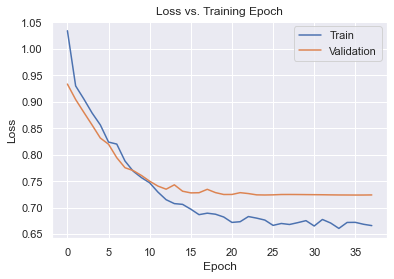

In [303]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [304]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [305]:
target

0

In [307]:
print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (0):
Validation AUC: 0.6779
Training AUC: 0.7458


In [308]:
print('SECONDARY TARGET ({}):'.format(1))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,1], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,1], y_pred_train), 4)))

SECONDARY TARGET (1):
Validation AUC: 0.591
Training AUC: 0.5869


In [309]:
print('SECONDARY TARGET ({}):'.format(2))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,2], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,2], y_pred_train), 4)))

SECONDARY TARGET (2):
Validation AUC: 0.6391
Training AUC: 0.6264


In [310]:
print('SECONDARY TARGET ({}):'.format(3))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,3], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,3], y_pred_train), 4)))

SECONDARY TARGET (3):
Validation AUC: 0.6768
Training AUC: 0.6653


# 10) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (second target)

In [387]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 1

In [388]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.35


In [389]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [390]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=4, val=1


In [391]:
keras.backend.clear_session()

from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', 
                   include_top=False, 
#                    pooling='avg',
                   input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
for layer in base_model.layers:
  if ('block5_' not in layer.name):
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')
base_model.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 273, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 273, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 273, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 136, 64)      0     

In [392]:
dropout = 0.4
l1_reg = 0.0001
l2_reg = 0.001

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
# x = Dense(units=128, activation='relu')(x)
x = Dense(units=128, 
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=2)(x) # adding Dropout for regularization between the Dense layers
x = Dense(units=64,
          activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
          bias_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout, seed=1)(x) # adding Dropout for regularization between the Dense layers
predictions = Dense(units=1, activation='sigmoid')(x) # 1 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [393]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [394]:
initial_learning_rate = 0.00025
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [395]:
model.optimizer.get_config()['learning_rate']

0.00025

In [396]:
# Exponential decay learning rate scheduler comes from: 
#      https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
def lr_exp_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    k = 0
    return lr * np.exp(-k*epoch)

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_delta=0.0001, min_lr=5e-6)
reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, patience=2, mode='max', min_delta=0.002, min_lr=1e-6)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model.optimizer.get_config()['learning_rate'], 7))))

# scheduler = LearningRateScheduler(lr_exp_decay, verbose=1)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=10, restore_best_weights=True)

history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=100, verbose=1, validation_data=val_iterator, 
                 callbacks=[
                     auc,
                     eval_callback,
                     reduce_lr,
                     lr_callback,
                     early_stopping,
#                      scheduler,
                     keras.callbacks.ModelCheckpoint(
                         'models_baby/model_10.{epoch:02d}-{auc:.4f}.hdf5',
                         save_best_only=False)
                 ])

Epoch 1/100
Learning Rate: 0.00025
4/4 [==============================] - 467s 125s/step - loss: 3.5135 - val_loss: 3.2452

val-roc-auc: 0.4894                                                                                                    

Epoch 2/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 452s 118s/step - loss: 3.1680 - val_loss: 2.9572

val-roc-auc: 0.5282                                                                                                    

Epoch 3/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 437s 111s/step - loss: 2.8771 - val_loss: 2.7055

val-roc-auc: 0.5474                                                                                                    

Epoch 4/100
Learning Rate: 0.0002500000118743628
4/4 [==============================] - 440s 112s/step - loss: 2.6317 - val_loss: 2.4956

val-roc-auc: 0.5837                                                                                

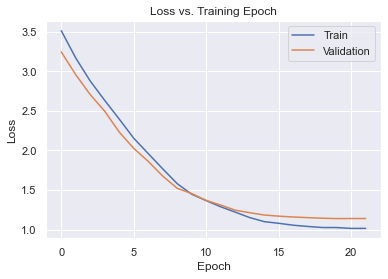

In [397]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

In [401]:
model.get_config()

{'name': 'model_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 273, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 3,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Functional',
   'con

In [403]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 3.90625e-06,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [398]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [399]:
target

1

In [400]:
# dropout = 0.4
# l1_reg = 0.0001
# l2_reg = 0.001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (1):
Validation AUC: 0.6389
Training AUC: 0.8139


In [386]:
# dropout = 0.3
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (1):
Validation AUC: 0.6311
Training AUC: 0.9003


In [363]:
# dropout = 0.35
# l1_reg = 0.00005
# l2_reg = 0.0005

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (1):
Validation AUC: 0.6595
Training AUC: 0.834


In [347]:
# dropout = 0.35
# l1_reg = 0.00001
# l2_reg = 0.0001

print('PRIMARY TARGET ({}):'.format(target))
print('Validation AUC: {}'.format(round(roc_auc_score(y_val[:,target], y_pred_val), 4)))
print('Training AUC: {}'.format(round(roc_auc_score(y_train[:,target], y_pred_train), 4)))

PRIMARY TARGET (1):
Validation AUC: 0.6224
Training AUC: 0.7687
